<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study2_2_%5Bada003%5D_autoencoder_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ada-003] Autoencoder: Generate Corresponding Embedding

## Set Up

### Imports

In [ ]:
!pip install tensorflow

In [ ]:
import os
import subprocess
import zipfile
import shutil
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import userdata
from scipy import spatial
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from plotnine import ggplot, geom_line, aes, ggsave, labs, theme, element_text, guides, guide_legend

### OSF Setup

In [ ]:
!pip install osfclient

In [ ]:
import osfclient.cli

In [ ]:
from osfclient.api import OSF
from osfclient.models import Project, Storage
from io import BytesIO

In [ ]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [ ]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [ ]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [ ]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

## Data

### Import corpora data from OSF

In [ ]:
!osf -p sakjg fetch osfstorage/corpora/arguana_corpus.zip

100% 121M/121M [00:01<00:00, 89.2Mbytes/s]


In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/ada003-autoencoder/ada_embeddings_dump.zip

100% 71.9M/71.9M [00:01<00:00, 54.4Mbytes/s]


In [ ]:
corpora_file_path = 'arguana_corpus.zip'
output_folder_path = 'arguana-corpus'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(corpora_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['arguana_corpus', '__MACOSX']


In [ ]:
embeddings_dump_file_path = 'ada_embeddings_dump.zip'
output_folder_path = 'current-data-dump/embeddings-dump'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(embeddings_dump_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['economy', 'test', 'training', '.ipynb_checkpoints']


### Functions for preparing training data

In [ ]:
def prepare_training_df(data: pd.DataFrame):
  """Drop rows that do not follow 'point' -> 'counter' pattern"""
  point_indices = data[data['type'] == 'point'].index
  counter_indices = data[data['type'] == 'counter'].index
  drop_indices = []
  for idx in point_indices:
    if (idx == len(data)-1) or (idx + 1 < len(data) and data.loc[idx + 1, 'type'] != 'counter'):
      drop_indices.append(idx)
  for idx in counter_indices:
    if idx > 0 and data.loc[idx - 1, 'type'] != 'point':
      drop_indices.append(idx)
  data = data.drop(drop_indices)
  data = data.select_dtypes(include=[np.number])
  data = data.reset_index(drop=True)
  return data

In [ ]:
def prepare_training_df_shuffled(data: pd.DataFrame):
  """Drop rows that do not follow 'point' -> 'counter' pattern"""
  point_indices = data[data['type'] == 'point'].index
  counter_indices = data[data['type'] == 'counter'].index
  drop_indices = []
  for idx in point_indices:
    if (idx == len(data)-1) or (idx + 1 < len(data) and data.loc[idx + 1, 'type'] != 'counter'):
      drop_indices.append(idx)
  for idx in counter_indices:
    if idx > 0 and data.loc[idx - 1, 'type'] != 'point':
      drop_indices.append(idx)
  data = data.drop(drop_indices)
  data = data.reset_index(drop=True)
  return data

In [ ]:
def make_x(data: pd.DataFrame) -> pd.DataFrame:
  """Make training and testing datasets"""
  x_train = data[data.index % 2 == 0].reset_index(drop=True)
  return x_train

def make_y(data: pd.DataFrame) -> pd.DataFrame:
  y_train = data[data.index % 2 != 0].reset_index(drop=True)
  return y_train

### Make global data

In [ ]:
training = pd.read_pickle("current-data-dump/embeddings-dump/training/global_embeddings.pkl")
test = pd.read_pickle("current-data-dump/embeddings-dump/test/global_embeddings.pkl")

In [ ]:
training_df = prepare_training_df(training.copy())
test_df = prepare_training_df(test.copy())

In [ ]:
x_train = make_x(training_df)

In [ ]:
y_train = make_y(training_df)

In [ ]:
x_test = make_x(test_df)

In [ ]:
y_test = make_y(test_df)

In [ ]:
y_train_test = pd.concat([y_train, y_test], axis=0)

### Make global data shuffled

In [ ]:
training_df_shuffled = prepare_training_df_shuffled(training.copy())

In [ ]:
y_train_shuffled = make_y(training_df_shuffled)

In [ ]:
y_train_shuffled = y_train_shuffled.groupby(['topic'], sort=False)
y_train_shuffled = y_train_shuffled.sample(frac=1).reset_index(drop=True)
y_train_shuffled = y_train_shuffled.select_dtypes(include=[np.number])

### Save global training df

In [ ]:
training_df_folder_path = 'current-data-dump/ada-autoencoder/'
training_df_file_path = f'{training_df_folder_path}training_df.pkl'
os.makedirs(training_df_folder_path, exist_ok=True)
with open(training_df_file_path, 'wb') as file:
  pickle.dump(training_df, file)
  print(f"File uploaded to {training_df_file_path}")

x_train_folder_path = 'current-data-dump/ada-autoencoder/'
x_train_file_path = f'{x_train_folder_path}x_train.pkl'
os.makedirs(x_train_folder_path, exist_ok=True)
with open(x_train_file_path, 'wb') as file:
  pickle.dump(x_train, file)
  print(f"File uploaded to {x_train_file_path}")

y_train_folder_path = 'current-data-dump/ada-autoencoder/'
y_train_file_path = f'{y_train_folder_path}y_train.pkl'
os.makedirs(y_train_folder_path, exist_ok=True)
with open(y_train_file_path, 'wb') as file:
  pickle.dump(y_train, file)
  print(f"File uploaded to {y_train_file_path}")

x_test_folder_path = 'current-data-dump/ada-autoencoder/'
x_test_file_path = f'{x_test_folder_path}x_test.pkl'
os.makedirs(x_test_folder_path, exist_ok=True)
with open(x_test_file_path, 'wb') as file:
  pickle.dump(x_test, file)
  print(f"File uploaded to {x_test_file_path}")

y_test_folder_path = 'current-data-dump/ada-autoencoder/'
y_test_file_path = f'{y_test_folder_path}y_test.pkl'
os.makedirs(y_test_folder_path, exist_ok=True)
with open(y_test_file_path, 'wb') as file:
  pickle.dump(y_test, file)
  print(f"File uploaded to {y_test_file_path}")

File uploaded to current-data-dump/ada-autoencoder/training_df.pkl
File uploaded to current-data-dump/ada-autoencoder/x_train.pkl
File uploaded to current-data-dump/ada-autoencoder/y_train.pkl
File uploaded to current-data-dump/ada-autoencoder/x_test.pkl
File uploaded to current-data-dump/ada-autoencoder/y_test.pkl


## Model

### Architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(1536, ), name="Input")
hidden_layer = tf.keras.layers.Dense(units=1536, activation="relu", name="Hidden")(input_layer)
output_layer = tf.keras.layers.Dense(units=1536, activation="linear", name="Output")(hidden_layer)

In [ ]:
# Model
autoencoder_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1536)]            0         
                                                                 
 Hidden (Dense)              (None, 1536)              2360832   
                                                                 
 Output (Dense)              (None, 1536)              2360832   
                                                                 
Total params: 4721664 (18.01 MB)
Trainable params: 4721664 (18.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Metric

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_global_y_train(y_true, y_pred):
  """global_metric"""
  global_training_df_32 = tf.cast(pd.concat([x_train, y_train, x_test, y_test]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

### Global Training

In [ ]:
# Global Model
global_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='global_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='global_training_log.csv', separator=',', append=True)
global_history = global_autoencoder_model.fit(
  x=x_train,
  y=y_train,
  batch_size=1,
  epochs=50,
  validation_data = (x_test, y_test),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/50
4060/4065 [============================>.] - ETA: 0s - loss: -0.6533 - metric_choose_argument_global_y_train: 0.0692
Epoch 1: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 51s 9ms/step - loss: -0.6533 - metric_choose_argument_global_y_train: 0.0694 - val_loss: -0.6825 - val_metric_choose_argument_global_y_train: 0.1199
Epoch 2/50
4056/4065 [============================>.] - ETA: 0s - loss: -0.7477 - metric_choose_argument_global_y_train: 0.2229
Epoch 2: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 26s 6ms/step - loss: -0.7477 - metric_choose_argument_global_y_train: 0.2231 - val_loss: -0.7115 - val_metric_choose_argument_global_y_train: 0.1984
Epoch 3/50
4055/4065 [============================>.] - ETA: 0s - loss: -0.7922 - metric_choose_argument_global_y_train: 0.4293
Epoch 3: saving model to global_autoencoder_weights.keras
4065/4065 [==============================] - 25s 6ms/s

In [ ]:
global_history_df = pd.DataFrame(global_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df.to_csv(f'{output_folder_path}global_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
global_autoencoder_model.save(f'{output_folder_path}global_autoencoder_model.keras')

### Global Shuffled Training

In [ ]:
# Global Shuffled Model
global_shuffled_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_shuffled_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_y_train]
)

global_shuffled_history = global_shuffled_autoencoder_model.fit(
  x=global_x_train,
  y=global_y_train_shuffled,
  batch_size=1,
  epochs=20,
  validation_data = (global_x_test, global_y_test)
)

Epoch 1/20
3252/3252 [==============================] - 33s 7ms/step - loss: -0.6000 - metric_choose_argument_global_y_train: 0.0178 - val_loss: -0.6385 - val_metric_choose_argument_global_y_train: 0.0603
Epoch 2/20
3252/3252 [==============================] - 17s 5ms/step - loss: -0.6845 - metric_choose_argument_global_y_train: 0.0529 - val_loss: -0.6577 - val_metric_choose_argument_global_y_train: 0.0664
Epoch 3/20
3252/3252 [==============================] - 17s 5ms/step - loss: -0.7221 - metric_choose_argument_global_y_train: 0.0984 - val_loss: -0.6640 - val_metric_choose_argument_global_y_train: 0.0836
Epoch 4/20
3252/3252 [==============================] - 17s 5ms/step - loss: -0.7492 - metric_choose_argument_global_y_train: 0.1845 - val_loss: -0.6567 - val_metric_choose_argument_global_y_train: 0.0689
Epoch 5/20
3252/3252 [==============================] - 17s 5ms/step - loss: -0.7725 - metric_choose_argument_global_y_train: 0.3137 - val_loss: -0.6433 - val_metric_choose_argumen

In [ ]:
global_shuffled_history_df = pd.DataFrame(global_shuffled_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
global_shuffled_history_df.to_csv(f'{output_folder_path}global_shuffled_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
global_shuffled_autoencoder_model.save(f'{output_folder_path}global_shuffled_autoencoder_model.keras')

## Export data

In [ ]:
def export_ada_autoencoder():
  """Export ada_autoencoder directory"""
  ada_autoencoder_file_path = 'current-data-dump/ada-autoencoder'
  ada_autoencoder_file_path_zip = 'current-data-dump/ada-autoencoder'
  shutil.make_archive(ada_autoencoder_file_path_zip, 'zip', ada_autoencoder_file_path)
  print(f"Zip file created at: {ada_autoencoder_file_path_zip}")
  result = subprocess.run([f"osf -p sakjg upload --force {ada_autoencoder_file_path_zip}.zip data-dump/ada003-autoencoder/ada_autoencoder.zip"], shell=True, capture_output=True, text=True)
  print(result.stderr)
  print(f"File: {ada_autoencoder_file_path_zip} uploaded at osfstorage")

## Import data

In [ ]:
def import_ada_autoencoder():
  """Import ada_autoencoder directory"""
  subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-autoencoder/ada_autoencoder.zip", shell=True)
  print("ada_autoencoder.zip successfully imported")
  ada_autoencoder_file_path_zip = 'ada_autoencoder.zip'
  ada_autoencoder_file_path = 'current-data-dump/ada-autoencoder'
  os.makedirs(ada_autoencoder_file_path, exist_ok=True)
  with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
    zip_ref.extractall(ada_autoencoder_file_path)
  extracted_files = os.listdir(ada_autoencoder_file_path)
  print("Files extracted:", extracted_files)

## Load global training history

In [ ]:
import_ada_autoencoder()

ada_autoencoder.zip successfully imported
Files extracted: ['global_shuffled_training_log.csv', 'global_autoencoder_model.keras', 'x_train.pkl', 'global_shuffled_training_plot.png', 'y_train.pkl', 'x_test.pkl', 'combined_global_training_plot.png', 'global_training_df.pkl', 'training_df.pkl', 'y_teset.pkl', 'global_shuffled_autoencoder_model.keras', 'y_test.pkl', 'global_training_plot.png', 'global_training_log.csv']


#### Unshuffled training history

In [ ]:
# Access training history
loaded_global_history = pd.DataFrame(pd.read_csv("current-data-dump/ada-autoencoder/global_training_log.csv"))
loaded_global_history = pd.melt(loaded_global_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
loaded_global_history = loaded_global_history.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
loaded_global_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_global_history['shuffled'] = False

In [ ]:
global_training_plot = ggplot(loaded_global_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(global_training_plot, "current-data-dump/ada-autoencoder/global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada-autoencoder/global_training_plot.png


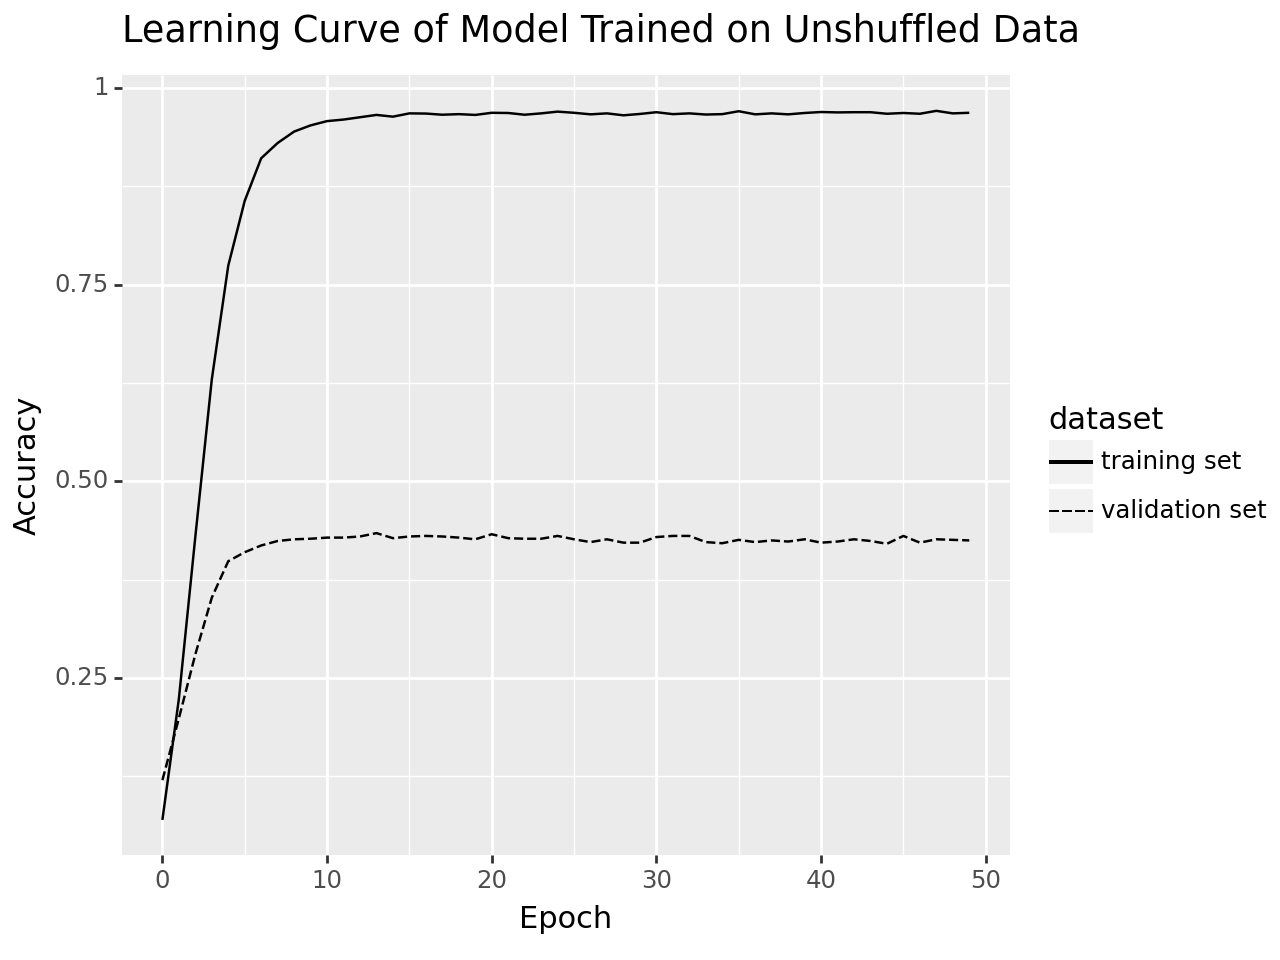

<Figure Size: (640 x 480)>

In [ ]:
global_training_plot

#### Shuffled training history

In [ ]:
# Access training history
loaded_global_shuffled_history = pd.DataFrame(pd.read_csv("current-data-dump/ada-autoencoder/global_shuffled_training_log.csv"))
loaded_global_shuffled_history = pd.melt(loaded_global_shuffled_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], var_name='dataset', value_name='accuracy')
loaded_global_shuffled_history = loaded_global_shuffled_history.replace(['metric_choose_argument_global_y_train', 'val_metric_choose_argument_global_y_train'], ['training set', 'validation set'])
loaded_global_shuffled_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_global_shuffled_history['shuffled'] = False

In [ ]:
global_shuffled_training_plot = ggplot(loaded_global_shuffled_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Shuffled Data', x='Epoch', y='Accuracy')
ggsave(global_shuffled_training_plot, "current-data-dump/ada-autoencoder/global_shuffled_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada-autoencoder/global_shuffled_training_plot.png


## Combined Training Plots

In [ ]:
combined_global_training_df = pd.concat([loaded_global_history, loaded_global_shuffled_history])

In [ ]:
combined_global_plot = (
  ggplot(combined_global_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='shuffled')) +
  geom_line(size=2) +
  labs(title='Learning Curve of Model Trained on Unshuffled vs. Within-Topic Shuffled Data', x='Epoch', y='Accuracy') +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=32),
    axis_text=element_text(size=24),
    legend_title=element_text(size=32, lineheight=1.5),
    legend_text=element_text(size=24, lineheight=1.5),
    plot_title=element_text(size=40, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(combined_global_plot, "current-data-dump/ada-autoencoder/combined_global_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada-autoencoder/combined_global_training_plot.png


## Category and Debate Training

#### Category Data (Economy)

In [ ]:
economy_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/economy/economy_embeddings.pkl")

In [ ]:
economy_training_df = prepare_training_df(economy_embeddings_data)
economy_x_train = make_x_train(economy_training_df)
economy_y_train = make_y_train(economy_training_df)
economy_x_test = make_x_test(economy_training_df)
economy_y_test = make_y_test(economy_training_df)

#### Debate Data (Economy)

In [ ]:
economy_debate_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/economy/business_economy_general_house_would_prohibit_retailers_selling_certain_items_embeddings.pkl")

In [ ]:
economy_debate_training_df = prepare_training_df(economy_debate_embeddings_data)
economy_debate_x_train = make_x_train(economy_debate_training_df)
economy_debate_y_train = make_y_train(economy_debate_training_df)
economy_debate_x_test = make_x_test(economy_debate_training_df)
economy_debate_y_test = make_y_test(economy_debate_training_df)

#### Category Training

In [ ]:
# Category Model
category_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
category_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="mse",
  metrics=['accuracy']
)
category_autoencoder_model.fit(
  x=economy_x_train,
  y=economy_y_train,
  batch_size=1,
  epochs=20,
  validation_data=(economy_x_test, economy_y_test)
)

#### Debate Training

In [ ]:
# Debate Model
debate_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
debate_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="mse",
  metrics=['accuracy']
)
debate_autoencoder_model.fit(
  x=economy_debate_x_train,
  y=economy_debate_y_train,
  batch_size=1,
  epochs=5
)

## Final Export

In [ ]:
export_ada_autoencoder()

Zip file created at: current-data-dump/ada-autoencoder

File: current-data-dump/ada-autoencoder uploaded at osfstorage
